In [1]:
!pip install torch torchvision captum

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 6.1 MB/s eta 0:00:00


## 소개
##### Captum을 사용하면 데이터 특징이 모델의 예측 또는 뉴런 활성화에 미치는 영향을 이해하고, 모델의 동작 방식을 알 수 있다.
##### 그리고 Integrated Gradients와 Guided GradCam과 같은 최첨단의 feature attribution 알고리즘을 적용할 수 있다.
##### 해당 자료에서는 아래와 같은 작업을 수행한다.
* 이미지 분류기의 예측을 해당 이미지의 특징에 표시하기
* 속성 결과를 시각화 하기

## 시작하기 전에
##### 모델은 PyTorch에 내장 된 이미지 분류기를 사용한다.
##### Captum은 샘플 이미지의 어떤 부분이 모델에 의해 만들어진 특정한 예측에 도움을 주는지 보여준다.

In [2]:
import torchvision
from torchvision import transforms
from PIL import Image
import requests
from io import BytesIO

model = torchvision.models.resnet18(pretrained=True).eval()

response = requests.get("https://image.freepik.com/free-photo/two-beautiful-puppies-cat-dog_58409-6024.jpg")
img = Image.open(BytesIO(response.content))

center_crop = transforms.Compose([
 transforms.Resize(256),
 transforms.CenterCrop(224),
])

normalize = transforms.Compose([
    transforms.ToTensor(),               # 이미지를 0에서 1사이의 값을 가진 Tensor로 변환
    transforms.Normalize(                # 0을 중심으로 하는 imagenet 픽셀의 rgb 분포를 따르는 정규화
     mean=[0.485, 0.456, 0.406],
     std=[0.229, 0.224, 0.225]
    )
])
input_img = normalize(center_crop(img)).unsqueeze(0)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 119MB/s]


## 속성 계산하기
##### 모델의 top-3 예측 중에 개와 고양이에 해당하는 클래스 208, 283이 있다.
##### Captum의 occlusion 알고리즘을 사용하여 각 예측을 입력의 해당 부분에 표시한다.

In [3]:
from captum.attr import Occlusion

occlusion = Occlusion(model)

strides = (3, 9, 9)               # 작을수록 = 세부적인 속성이지만 느림
target=208,                       # ImageNet에서 Labrador의 인덱스
sliding_window_shapes=(3,45, 45)  # 객체의 모양을 변화시키기에 충분한 크기를 선택
baselines = 0                     # 이미지를 가릴 값, 0은 회색

attribution_dog = occlusion.attribute(input_img,
                                       strides = strides,
                                       target=target,
                                       sliding_window_shapes=sliding_window_shapes,
                                       baselines=baselines)


target=283,                       # ImageNet에서 Persian cat의 인덱스
attribution_cat = occlusion.attribute(input_img,
                                       strides = strides,
                                       target=target,
                                       sliding_window_shapes=sliding_window_shapes,
                                       baselines=0)

##### Captum은 Occlusion 외에도 Integrated Gradients, Deconvolution, GuidedBackprop, Guided GradCam, DeepLift, 그리고 GradientShap과 같은 많은 알고리즘을 제공한다.

## 결과 시각화하기
##### Captum의 visualization 유틸리티는 그림과 텍스트 입력 모두에 대한 속성 결과를 시각화 할 수 있는 방법을 제공한다.

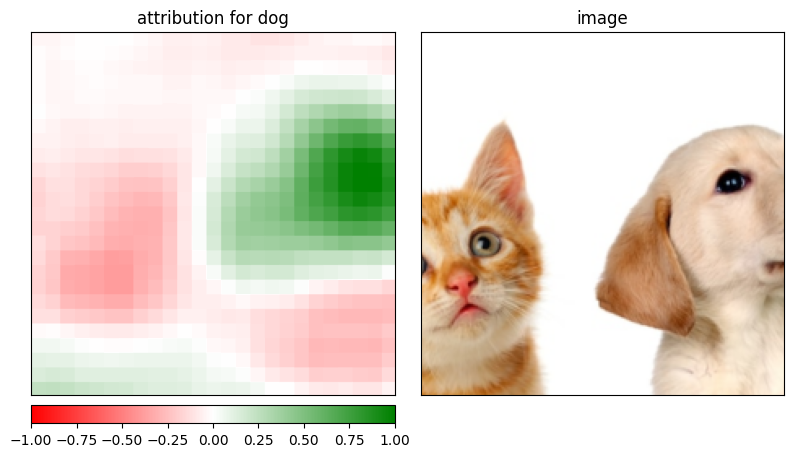

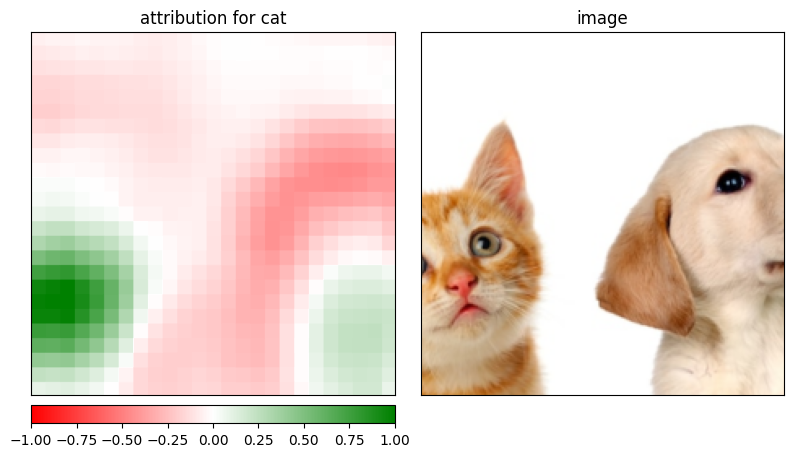

In [5]:
import numpy as np
from captum.attr import visualization as viz

# 계산 속성 Tensor를 이미지 같은 numpy 배열로 변환합니다.
attribution_dog = np.transpose(attribution_dog.squeeze().cpu().detach().numpy(), (1,2,0))

vis_types = ["heat_map", "original_image"]
vis_signs = ["all", "all"] # "positive", "negative", 또는 모두 표시하는 "all"
# positive 속성은 해당 영역의 존재가 예측 점수를 증가시킨다는 것을 의미합니다.
# negative 속성은 해당 영역의 존재가 예측 점수를 낮추는 오답 영역을 의미합니다.

_ = viz.visualize_image_attr_multiple(attribution_dog,
                                      np.array(center_crop(img)),
                                      vis_types,
                                      vis_signs,
                                      ["attribution for dog", "image"],
                                      show_colorbar = True
                                     )


attribution_cat = np.transpose(attribution_cat.squeeze().cpu().detach().numpy(), (1,2,0))

_ = viz.visualize_image_attr_multiple(attribution_cat,
                                      np.array(center_crop(img)),
                                      ["heat_map", "original_image"],
                                      ["all", "all"], # positive/negative 속성 또는 all
                                      ["attribution for cat", "image"],
                                      show_colorbar = True
                                     )

##### 만약 데이터가 텍스트인 경우 visualization.visualize_text()에 탐색할 수 있다.